This is an implementation of the paper Learning Deep Representation for Graph Clustering

Use the Wine dataset for this problem 4 . However, for this problem, use the cosine similarity
measure on the features to convert the dataset to a graph with weighted edges and attributed nodes, where
each node corresponds to a data point with attributes and each edge is weighted by the similarity measure.




In [0]:
import numpy as np
import argparse
from tqdm import tqdm
from sklearn.datasets import load_wine
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import normalized_mutual_info_score
from torch import nn, optim
import torch

from sklearn.metrics import mean_squared_error as mse,accuracy_score as ac

import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from collections import OrderedDict
from sklearn.cluster import KMeans

The graph encoder model as stated in the paper

In [0]:
class GraphEncoder(nn.Module):
    def __init__(self, layers, clusters):
        super(GraphEncoder, self).__init__()

        self.layers = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(layers[0], layers[1]),
            'sig1': nn.Sigmoid(),
            'lin2': nn.Linear(layers[1], layers[2]),
            'sig2': nn.Sigmoid(),
            'lin3': nn.Linear(layers[2], layers[3]),
            'sig3': nn.Sigmoid(),
            'lin4': nn.Linear(layers[3], layers[4]),
            'sig4': nn.Sigmoid(),
            }))
        self.clusters = clusters

        self.outputs = {}

        self.layers[0].register_forward_hook(self.get_activation('lin1'))
        self.layers[2].register_forward_hook(self.get_activation('lin2'))
        self.layers[4].register_forward_hook(self.get_activation('lin3'))
    
    def get_activation(self, name):
        def hook(module, input, output):
            self.outputs[name] = output
        return hook

    def forward(self, x):
        output = self.layers(x)
        return output

    def layer_activations(self, layername):
        return torch.mean(torch.sigmoid(self.outputs[layername]), dim=0)

    def sparse_result(self, rho, layername):
        rho_hat = self.layer_activations(layername)
        return rho * np.log(rho) - rho * torch.log(rho_hat) + (1 - rho) * np.log(1 - rho) \
                - (1 - rho) * torch.log(1 - rho_hat)

    def kl_div(self, rho):
        first = torch.mean(self.sparse_result(rho, 'lin1'))
        second = torch.mean(self.sparse_result(rho, 'lin2'))
        return first + second

    def get_index_by_name(self, name):
        return list(dict(self.layers.named_children()).keys()).index(name)

    def loss(self, x_hat, x, beta, rho):
        loss = F.mse_loss(x_hat, x) + beta * self.kl_div(rho)
        return loss

    def get_cluster(self):
        kmeans = KMeans(n_clusters=self.clusters).fit(self.outputs['lin2'].detach().cpu().numpy())
        self.centroids = kmeans.cluster_centers_
        return kmeans.labels_
# model=GraphEncoder()
# model

some important hyper parameters with description

In [0]:

dataset='wine'  # we are working with this data-set for this problem
layers=[128,64,128] # the autoencoder layer structure (hidden structure)
beta=0.01 #weightage of sparsity penalty
rho=0.5 # sparsity parameter
lr=0.01 # learning rate 
epoch=200 # 200 iterations was enough
device='cuda' # change if gpu is unavailable

In [8]:

from sklearn.model_selection import train_test_split as tts
def main():
    global dataset,layers,beta,rho,lr,epoch,device,X,Y,kmeans_labels,S
    
    data = load_wine()

    X = data.data
    Y = data.target
   

    k = len(np.unique(Y))


    #0 mean 1 variance normalization

    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    
    # Obtain Similarity matrix
    S = cosine_similarity(X, X)

    ##this part is important ,preparing the train set
    D = np.diag(1.0 / np.sqrt(S.sum(axis=1)))
    X_train = torch.tensor(D.dot(S).dot(D)).float().to(device)
    ##
    layers = [len(X_train)] + layers + [len(X_train)]

    model = GraphEncoder(layers, k).to(device)
    print(model)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    with tqdm(total=epoch) as tq:
        for epoch in range(1, epoch + 1):
            optimizer.zero_grad()
            X_hat = model(X_train)
            loss = model.loss(X_hat, X_train, beta, rho)
            nmi = normalized_mutual_info_score(model.get_cluster(), Y, average_method='arithmetic')

            loss.backward()
            optimizer.step()

            tq.set_postfix(loss='{:.3f}'.format(loss), nmi='{:.3f}'.format(nmi))
            tq.update()
        #print(model.get_cluster())
        kmeans_labels=model.get_cluster()
        print(kmeans_labels)
        print(Y)


if __name__ == '__main__':
    main()

  0%|          | 0/200 [00:00<?, ?it/s]

GraphEncoder(
  (layers): Sequential(
    (lin1): Linear(in_features=178, out_features=128, bias=True)
    (sig1): Sigmoid()
    (lin2): Linear(in_features=128, out_features=64, bias=True)
    (sig2): Sigmoid()
    (lin3): Linear(in_features=64, out_features=128, bias=True)
    (sig3): Sigmoid()
    (lin4): Linear(in_features=128, out_features=178, bias=True)
    (sig4): Sigmoid()
  )
)


100%|██████████| 200/200 [00:18<00:00, 10.99it/s, loss=0.000, nmi=0.342]

[2 0 2 0 2 2 2 2 2 2 2 2 2 0 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 0 2 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 1 1 0 2 0 0 2 0 0 0 1 0 2 2 2
 0 0 0 2 0 2 0 2 0 0 0 2 0 0 2 0 0 0 0 0 0 0 1 2 0 0 2 2 2 2 2 0 2 2 2 0 1
 2 0 0 2 1 0 2 0 0 2 0 0 0 1 2 2 0 2 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1
 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


manually selecting the labels to match with the original

In [33]:
print(kmeans_labels)
for i in range(len(kmeans_labels)):
  if kmeans_labels[i]==0:
    kmeans_labels[i]=1
  elif kmeans_labels[i]==1:
    kmeans_labels[i]=0
  elif kmeans_labels[i]==2:
    kmeans_labels[i]=2
print(kmeans_labels)    
print(ac(Y,kmeans_labels))


[1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 2 2 2 1 0 0 1 0 0 0 0 0 1 1 1
 0 0 0 1 0 1 0 1 0 2 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0
 1 0 0 0 0 0 1 2 0 0 0 0 0 0 1 1 0 1 0 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 0 1 1 0 1 1 1 1 1 0 0 0
 1 1 1 0 1 0 1 0 1 2 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1
 0 1 1 1 1 1 0 2 1 1 1 1 1 1 0 0 1 0 1 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
0.8202247191011236


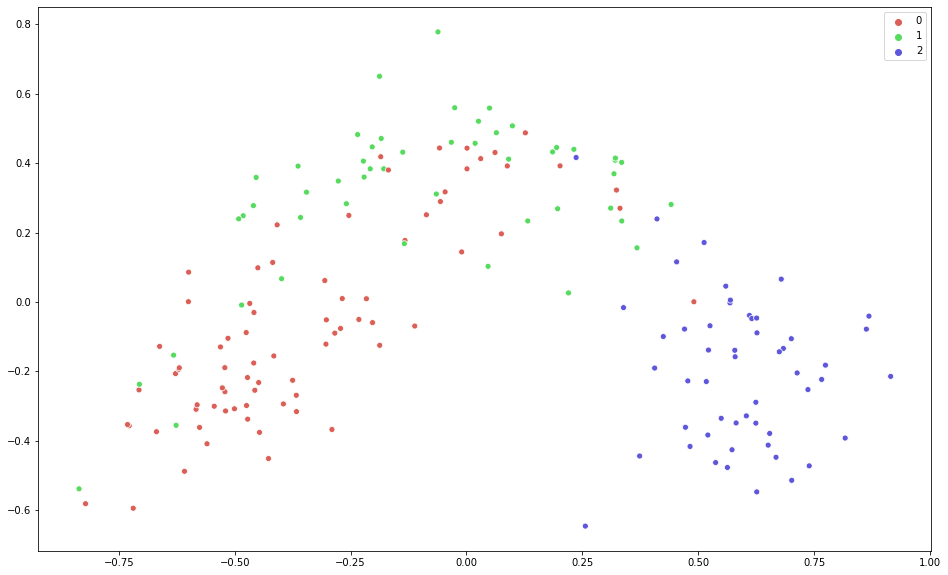

In [34]:
from sklearn.decomposition import PCA as pca
import matplotlib.pyplot as plt
import seaborn as sns
wine_pca_two=pca(n_components=2).fit_transform(X)


plt.figure(figsize=(16,10))
sns.scatterplot(
    x=wine_pca_two[:,0], y=wine_pca_two[:,1],
    hue=kmeans_labels,
    palette=sns.color_palette("hls", 3),
    legend="full",
    alpha=1
)

In [0]:
import networkx as nx

In [0]:
G=nx.from_numpy_matrix(S)

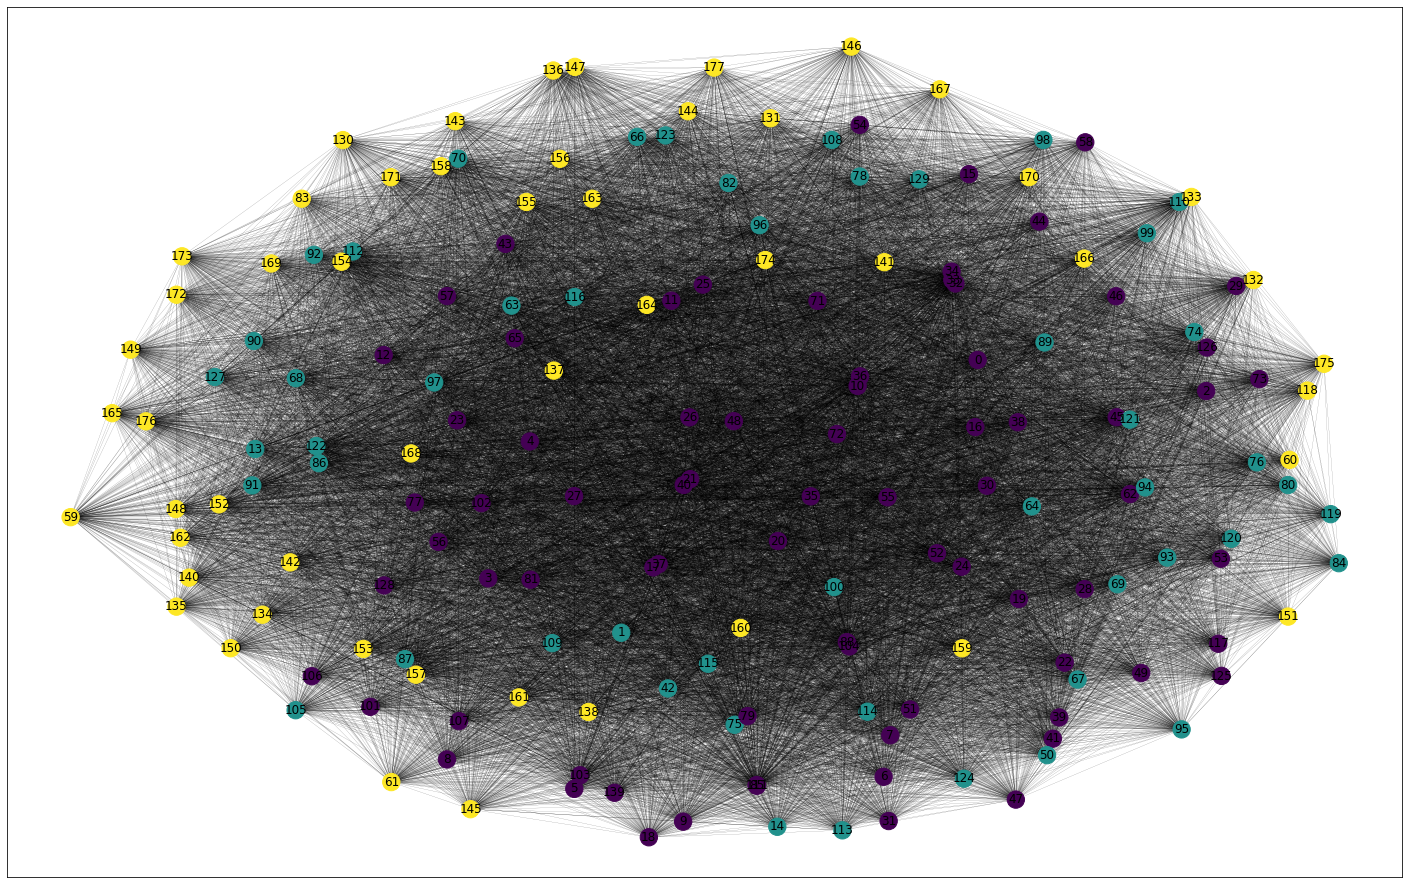

In [37]:
plt.figure(figsize=(25,16))
nx.draw_networkx(G,node_color=kmeans_labels,width=.1)